# Occasionally binding constraint model - Solved with ANN (PyTorch)

This notebook solves the Bianchi model with occasionally binding collateral constraints using PyTorch.

**Method**: Fischer-Burmeister complementarity with neural network approximation

## Setup: Imports and Device Selection

Check for CUDA availability and set computation device.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import quantecon as qe

#optimizers
from adabelief_pytorch import AdaBelief 
# from sophia.sophia import SophiaG


# ============================================================================ #
#                           0. DEVICE SELECTION                                #
# ============================================================================ #
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"--- Using device: {device} ---")



--- Using device: cuda ---


## Model Calibration

Standard Bianchi (2011) parameters:
- σ: Risk aversion (2.0)
- κ: Borrowing constraint (0.2808)
- β: Discount factor (0.91)
- ω: Weight on traded goods (0.31)
- η: Elasticity of substitution (0.5)

In [2]:
DTYPE = torch.float32

# --- Structural parameters --- #
σ = torch.tensor(2.0, dtype=DTYPE, device=device)
κ = torch.tensor(0.2808, dtype=DTYPE, device=device)
β = torch.tensor(0.91, dtype=DTYPE, device=device)
ω = torch.tensor(0.31, dtype=DTYPE, device=device)
η = torch.tensor(0.5, dtype=DTYPE, device=device)
τ = torch.tensor(0.2, dtype=DTYPE, device=device)

# --- State variables --- #
yT = torch.tensor(1.0, dtype=DTYPE, device=device)
yN = torch.tensor(1.0, dtype=DTYPE, device=device)

# --- Grids --- #
l_min, l_max = 0.1, 0.9
n_l = 300
l_grid_np = np.linspace(l_min, l_max, n_l, dtype=np.float32)
l_grid = torch.tensor(l_grid_np, dtype=DTYPE, device=device)

# --- Stochastic Processes (MODIFIED: All NumPy ops are now Float32) --- #
# Government default cost process
ν_bar = np.float32(1.82)
ρ_ν   = np.float32(0.97)
σ_ν   = np.float32(0.14)
n_ν   = 5

# Non performing loans process
ϕ_bar = np.float32(0.021)
ρ_ϕ   = np.float32(0.82)
σ_ϕ   = np.float32(0.33)
n_ϕ   = 5

# Define the VAR(1) parameters as float32
A = np.array([[ρ_ν, 0.0], [0.0, ρ_ϕ]], dtype=np.float32)
Σ = np.array([[σ_ν**2, 0.0], [0.0, σ_ϕ**2]], dtype=np.float32)
C = np.sqrt(Σ)
n_shocks_grid = [n_ν, n_ϕ]

# Discretize the VAR(1) process
mc = qe.markov.discrete_var(A, C, grid_sizes=n_shocks_grid)
S0_np = mc.state_values.astype(np.float32)
Π_np = mc.P.astype(np.float32)

# Transform the grid points, ensuring all operations maintain float32
S_np = np.zeros_like(S0_np)
S_np[:, 0] = S0_np[:, 0] + ν_bar
S_np[:, 1] = np.exp(S0_np[:, 1] + np.log(ϕ_bar).astype(np.float32))

n_s = S_np.shape[0]

# Move final matrices to the selected device
Π = torch.tensor(Π_np, dtype=DTYPE, device=device)
S = torch.tensor(S_np, dtype=DTYPE, device=device)

# --- Interest rates --- #
i_l = torch.tensor(0.05, dtype=DTYPE, device=device)



## Economic Functions

Core equilibrium conditions:
- `du_dcT`: Marginal utility of traded consumption
- `price_nt`: Price of non-traded goods (from intratemporal optimality)

In [3]:
def du_dcT(ct, yn):
    return torch.where(
        ct > 0,
        ω * ct**(-1/η) * (ω*ct**((η-1)/η) + (1-ω)*yn**((η-1)/η))**((1-σ*η)/(η-1)),
        torch.tensor(999_999.0, dtype=DTYPE, device=device)
    )

def price_nt(ct, yn):
    return (1-ω)/ω * (torch.max(ct, torch.tensor(1e-9, device=device)) / yn)**(1/η)



## Neural Network Architecture

**Input**: 3D state (l, ν, φ)  
**Output**: Policy l' ∈ [0.1, 0.9]  
**Layers**: 3 → 256 → 128 → 1 (ReLU activations)

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, q1, q2, policy_dim, l_min, l_max, t_sigmoid):
        super(PolicyNetwork, self).__init__()
        self.l_min = l_min
        self.l_max = l_max
        self.T_sigmoid = t_sigmoid
        self.layers = nn.Sequential(
            nn.Linear(state_dim, q1), nn.ReLU(),
            nn.Linear(q1, q2), nn.ReLU(),
            nn.Linear(q2, policy_dim)
        )
    def forward(self, x):
        x = self.layers(x)
        return self.l_min + (self.l_max - self.l_min) * torch.sigmoid(x / self.T_sigmoid)

# --- Model Architecture --- #
state_dim = 3
policy_dim = 1
Q1 = 256
Q2 = 128
T_sigmoid = 1.0

model = PolicyNetwork(state_dim, Q1, Q2, policy_dim, l_min, l_max, T_sigmoid).to(device)

# --- Hyperparameters --- #
learning_rate_initial = 1e-3
learning_rate_final = 1e-6
epochs = 50000
epochs_warmup = 30000
batch_size = 32
huber_delta = 0.1

# --- Optimizer --- #
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_initial)
# optimizer = torch.optim.SophiaH(model.parameters(), lr=learning_rate_initial)
optimizer = AdaBelief(model.parameters(), lr=learning_rate_initial)
# optimizer = SophiaG(model.parameters(), lr=learning_rate_initial)

# --- State Space Normalization --- #
shock_min = torch.min(S, dim=0, keepdim=True)[0]
shock_max = torch.max(S, dim=0, keepdim=True)[0]
shock_range = shock_max - shock_min



Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


## State Normalization and Sampling

Normalize shock variables while keeping debt in original scale.

In [5]:
def normalize_state(batch):
    l = batch[:, 0:1]
    shocks = batch[:, 1:3]
    normalized_shocks = (shocks - shock_min) / shock_range
    return torch.cat([l, normalized_shocks], dim=1)

def sample_states(batch_size):
    loans = np.random.rand(batch_size, 1).astype(np.float32) * (l_max - l_min) + l_min
    shock_indices = np.random.randint(0, n_s, size=batch_size)
    shocks = S_np[shock_indices, :]
    return np.hstack([loans, shocks]), shock_indices



## Loss Function: Fischer-Burmeister

The Fischer-Burmeister function handles complementarity slackness:

$$\text{FB}(a, b) = a + b - \sqrt{a^2 + b^2}$$

Where:
- a = Euler equation residual
- b = Constraint slack (borrowing limit - debt)

At optimum: FB = 0 (works whether constraint binds or not)

In [6]:
huber_loss_fn = nn.HuberLoss(reduction='mean', delta=huber_delta)

def ann_loss(m, batch, shock_indices):
    current_batch_size = batch.shape[0]
    normalized_batch = normalize_state(batch)
    l, ϕ = batch[:, 0:1], batch[:, 2:3]
    lp = m(normalized_batch)
    ct = yT * (1 - τ) - l * (1.0 - ϕ) + lp / (1.0 + i_l)
    pn = price_nt(ct, yN)

    # --- Vectorized Expectation Calculation ---
    lp_expanded = lp.repeat_interleave(n_s, dim=0)
    S_tiled = S.repeat(current_batch_size, 1)
    state_prime_unnormalized = torch.cat([lp_expanded, S_tiled], dim=1)
    lpp = m(normalize_state(state_prime_unnormalized))
    ϕ_p_tiled = S_tiled[:, 1:2]
    ct_prime = yT * (1 - τ) - lp_expanded * (1.0 - ϕ_p_tiled) + lpp / (1.0 + i_l)
    future_marg_utils = du_dcT(ct_prime, yN).view(current_batch_size, n_s)
    E_λp = torch.matmul(future_marg_utils, Π)
    E_λp_final = E_λp[torch.arange(current_batch_size), shock_indices].unsqueeze(1)
    
    # --- Fischer-Burmeister Residual ---
    λ = du_dcT(ct, yN)
    borr_const = κ * (pn * yN + yT * (1 - τ))
    epsilon = 1e-9
    a_norm = 1.0 - (β * E_λp_final * (1.0 + i_l)) / (λ + epsilon)
    b_norm = 1.0 - lp / (borr_const + epsilon)
    fb_residual = a_norm + b_norm - torch.sqrt(a_norm**2 + b_norm**2)
    loss = huber_loss_fn(fb_residual, torch.zeros_like(fb_residual))
    return loss



## Training Loop

Train for 50,000 epochs with:
- Initial learning rate: 1e-3
- Final learning rate: 1e-6 (after epoch 30,000)
- Optimizer: AdaBelief
- Batch size: 32

In [7]:
print("--- Starting PyTorch ANN Training ---")
losses = []
loop = tqdm(range(epochs), desc="Training Policy ANN:")

for epoch in loop:
    if epoch == epochs_warmup:
        print(f"\n--- Switched to final learning rate: {learning_rate_final} ---")
        for g in optimizer.param_groups:
            g['lr'] = learning_rate_final

    batch_np, shock_indices = sample_states(batch_size)
    batch = torch.tensor(batch_np, dtype=DTYPE, device=device)

    # 1st order optimizers (Adam, AdaBelief)
    # optimizer.zero_grad()
    # loss = ann_loss(model, batch, shock_indices)
    # loss.backward()
    # optimizer.step()

    # 2nd order optimizers (sophia)
    def closure():
        optimizer.zero_grad()
        loss = ann_loss(model, batch, shock_indices)
        loss.backward()
        return loss
    loss = optimizer.step(closure)

    losses.append(loss.item())
    loop.set_postfix(loss=f"{loss.item():.2e}", lr=optimizer.param_groups[0]['lr'])

print("--- Training Complete ---")


--- Starting PyTorch ANN Training ---


Training Policy ANN::  60%|██████    | 30009/50000 [05:52<03:18, 100.73it/s, loss=2.32e-03, lr=1e-6] 


--- Switched to final learning rate: 1e-06 ---


Training Policy ANN:: 100%|██████████| 50000/50000 [09:36<00:00, 86.70it/s, loss=3.61e-05, lr=1e-6] 

--- Training Complete ---


## Results Visualization

Plot:
1. Training loss convergence
2. Policy function l'(l) - shows kink where constraint binds
3. Kuhn-Tucker multiplier μ(l) - positive when constrained

Plotting learned policy function...


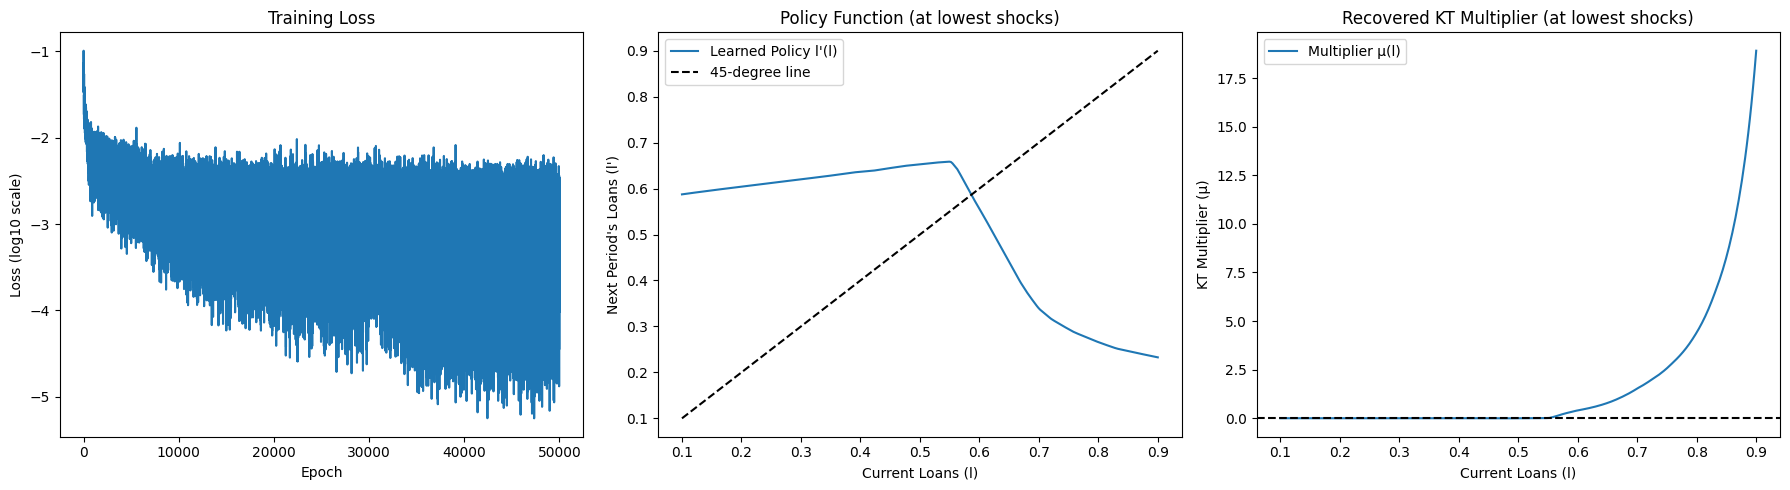

In [8]:
def recover_multiplier(m, batch, shock_indices):
    current_batch_size = batch.shape[0]
    normalized_batch = normalize_state(batch)
    l, ϕ = batch[:, 0:1], batch[:, 2:3]
    lp = m(normalized_batch)
    ct = yT * (1 - τ) - l * (1.0 - ϕ) + lp / (1.0 + i_l)
    lp_expanded = lp.repeat_interleave(n_s, dim=0)
    S_tiled = S.repeat(current_batch_size, 1)
    state_prime_unnormalized = torch.cat([lp_expanded, S_tiled], dim=1)
    lpp = m(normalize_state(state_prime_unnormalized))
    ϕ_p_tiled = S_tiled[:, 1:2]
    ct_prime = yT * (1 - τ) - lp_expanded * (1.0 - ϕ_p_tiled) + lpp / (1.0 + i_l)
    future_marg_utils = du_dcT(ct_prime, yN).view(current_batch_size, n_s)
    E_λp = torch.matmul(future_marg_utils, Π)
    E_λp_final = E_λp[torch.arange(current_batch_size), shock_indices].unsqueeze(1)
    λ = du_dcT(ct, yN)
    μ = λ / (1.0 + i_l) - β * E_λp_final
    return μ

# --- Prepare data for plotting ---
print("Plotting learned policy function...")
plot_ν_val = S_np[0, 0]
plot_ϕ_val = S_np[0, 1]
plot_grid_unnormalized_np = np.hstack([
    l_grid_np.reshape(-1, 1),
    np.full((n_l, 1), plot_ν_val, dtype=np.float32),
    np.full((n_l, 1), plot_ϕ_val, dtype=np.float32)
])
plot_grid_unnormalized = torch.tensor(plot_grid_unnormalized_np, device=device)

model.eval()
with torch.no_grad():
    learned_policy_tensor = model(normalize_state(plot_grid_unnormalized))
    plot_shock_indices = np.zeros(n_l, dtype=int)
    recovered_mu_tensor = recover_multiplier(model, plot_grid_unnormalized, plot_shock_indices)

learned_policy = learned_policy_tensor.cpu().numpy()
recovered_mu = recovered_mu_tensor.cpu().numpy()

# --- Create plots ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.plot(np.log10(losses))
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss (log10 scale)")
ax2.plot(l_grid_np, learned_policy.flatten(), label="Learned Policy l'(l)")
ax2.plot(l_grid_np, l_grid_np, 'k--', label="45-degree line")
ax2.set_title("Policy Function (at lowest shocks)")
ax2.set_xlabel("Current Loans (l)")
ax2.set_ylabel("Next Period's Loans (l')")
ax2.legend()
ax3.plot(l_grid_np, recovered_mu.flatten(), label="Multiplier μ(l)")
ax3.axhline(0, color='k', linestyle='--')
ax3.set_title("Recovered KT Multiplier (at lowest shocks)")
ax3.set_xlabel("Current Loans (l)")
ax3.set_ylabel("KT Multiplier (μ)")
ax3.legend()
plt.tight_layout()
# plt.savefig("results_pytorch.png")
# print("\n--- Plot saved to results_pytorch.png ---")



## Interpretation

**Policy Function Kink**: Marks the transition from unconstrained to constrained borrowing

**Multiplier μ**:
- μ = 0: Interior solution (constraint not binding)
- μ > 0: Constraint binds (household wants more debt)

The kink location indicates the debt threshold for sudden stops.